# Tesla Motors Stock Prediction using Numerical and Textual Analysis

In [1]:
#!pip install pmdarima

In [2]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
import matplotlib
from scipy.stats import norm

matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\PARAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\PARAS\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
stock= pd.read_csv(r"C:\Users\PARAS\Downloads\TSLA.csv")
stock.head(5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-06-09,46.995998,47.066002,45.411999,45.872002,45.872002,22460500
1,2016-06-10,45.478001,45.594002,43.683998,43.757999,43.757999,30133000
2,2016-06-13,43.900002,45.153999,43.532001,43.574001,43.574001,20965000
3,2016-06-14,43.776001,44.439999,42.506001,42.992001,42.992001,17901000
4,2016-06-15,43.389999,44.380001,43.026001,43.540001,43.540001,14542500


In [4]:
stock.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [5]:
stock['Date'].min()

'2016-06-09'

In [6]:
stock.Date = pd.to_datetime(stock.Date, format='%Y%m%d', errors='ignore')

In [7]:
cols = ['High', 'Low', 'Open', 'Volume', 'Adj Close']
#stock.drop(cols, axis=1, inplace=True)
stock = stock.sort_values('Date')

In [8]:
stock.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
stock = stock.groupby('Date')['Close'].sum().reset_index()

In [10]:

stock.head()

,Date,Close
0,2016-06-09,45.872002
1,2016-06-10,43.757999
2,2016-06-13,43.574001
3,2016-06-14,42.992001
4,2016-06-15,43.540001


In [11]:
stock = stock.set_index('Date')
stock.index

Index(['2016-06-09', '2016-06-10', '2016-06-13', '2016-06-14', '2016-06-15',
       '2016-06-16', '2016-06-17', '2016-06-20', '2016-06-21', '2016-06-22',
       ...
       '2021-05-25', '2021-05-26', '2021-05-27', '2021-05-28', '2021-06-01',
       '2021-06-02', '2021-06-03', '2021-06-04', '2021-06-07', '2021-06-08'],
      dtype='object', name='Date', length=1258)

Our current datetime data can be tricky to work with, therefore, we will use the averages daily sales value for that month instead, and we are using the start of each month as the timestamp.



In [12]:
#y = stock['Close'].resample('M').mean()
stock.index = pd.to_datetime(stock.index)

monthly_mean = stock.Close.resample('M').mean()

In [13]:
monthly_mean['2016':]

Date
2016-06-30     42.255125
2016-07-31     44.675800
2016-08-31     44.746870
2016-09-30     40.451238
2016-10-31     40.336667
                 ...    
2021-02-28    794.269470
2021-03-31    656.802607
2021-04-30    709.618094
2021-05-31    616.753000
2021-06-30    601.605011
Freq: M, Name: Close, Length: 61, dtype: float64

#  Visualizing Close time series data


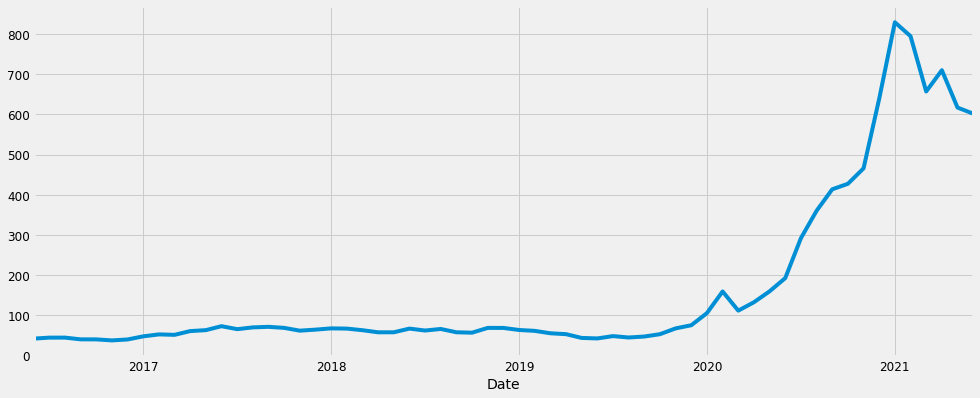

In [14]:
monthly_mean.plot(figsize=(15, 6))
plt.show()


Some distinguishable patterns appear when we plot the data. The time-series has seasonality pattern

We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

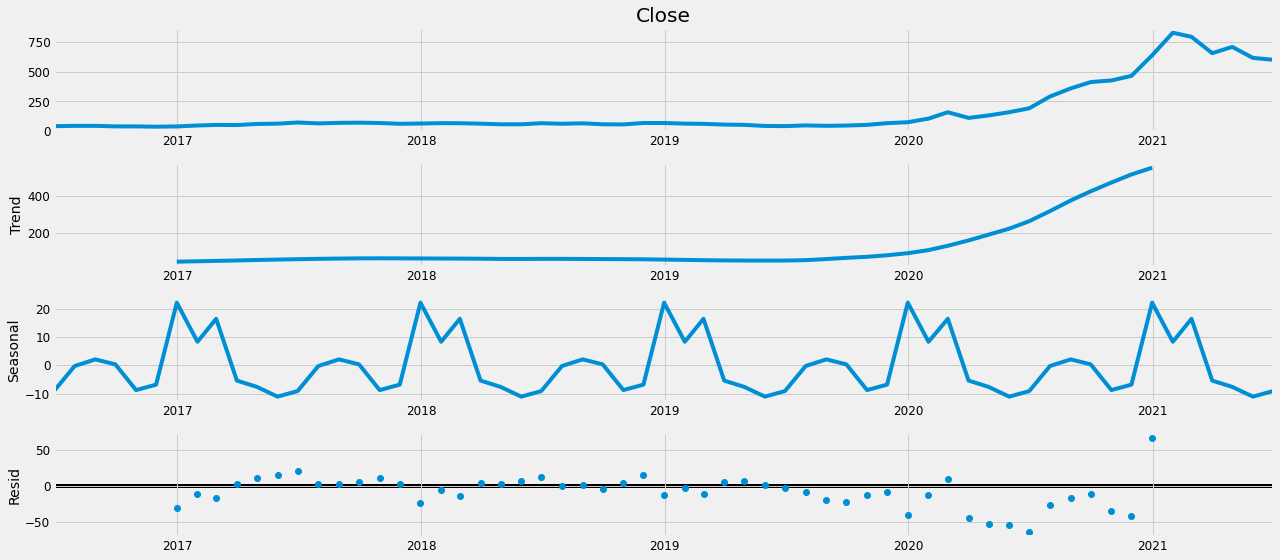

In [15]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

decomposition = sm.tsa.seasonal_decompose(monthly_mean, model='additive')
fig = decomposition.plot()
plt.show()

In [16]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [17]:
l_param = []
l_param_seasonal=[]
l_results_aic=[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            l_param.append(param)
            l_param_seasonal.append(param_seasonal)
            l_results_aic.append(results.aic)
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:858.3486066616772
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:853.3836436817112
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:679.559498995366
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:679.6489455140429
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:850.2181716102498
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:852.1491419103186
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:679.9422558182545


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:682.3211285286402
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:786.702743594891
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:779.7718977622711
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:620.7493188921809
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:619.7878405785236
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:775.7012265763534
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:790.673433044523
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:620.0341158535423
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:624.0204052509184
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:631.4913881826398
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:631.9287166396039
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:511.4247457256285


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:2045.7070973179461
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:631.8889812679446
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:633.8560206763527
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:513.4219453193075


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:2085.255880218369
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:624.943336971455
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:623.4675456060178
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:498.87993028317976


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:2380.362853766488
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:623.3142790192342
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:624.8959961039963
ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:499.69552423372863


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:1960.4864570930483
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:648.1377745063307
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:648.8098783397995
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:526.5271959443645
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:528.5263534746504
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:648.8868617840575
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:650.7980432489721
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:528.5264075243904


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:530.4695702847056
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:641.4102906438658
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:640.0943742925065
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:513.7621901970678
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:514.3439368719232
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:640.1405752891434
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:641.6364743062028
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:514.4765259562892
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:516.3439180683687
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:626.6499858157541
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:626.6833339880046
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:507.6503290995186


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:2239.820113976057
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:626.6911827578
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:628.6082007068043
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:509.64602782205446


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:2261.348792694867
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:625.6314472347625
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:622.3730491886691
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:497.82653143952166


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:1937.8788687330557
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:621.7441368027014
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:623.3064799110987
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:498.9260906369274
ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:1704.7527114672212


C:\Users\PARAS\anaconda3\anaconda\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [18]:
minimum=l_results_aic[0]
for i in l_results_aic[1:]:
    if i < minimum: 
        minimum = i
i=l_results_aic.index(minimum)

In [19]:

mod = sm.tsa.statespace.SARIMAX(monthly_mean,
                                order=l_param[i],
                                seasonal_order=l_param_seasonal[i],
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2728      0.144     -1.897      0.058      -0.555       0.009
ma.L1          1.0000    367.856      0.003      0.998    -719.985     721.985
sigma2      1538.9657   5.66e+05      0.003      0.998   -1.11e+06    1.11e+06


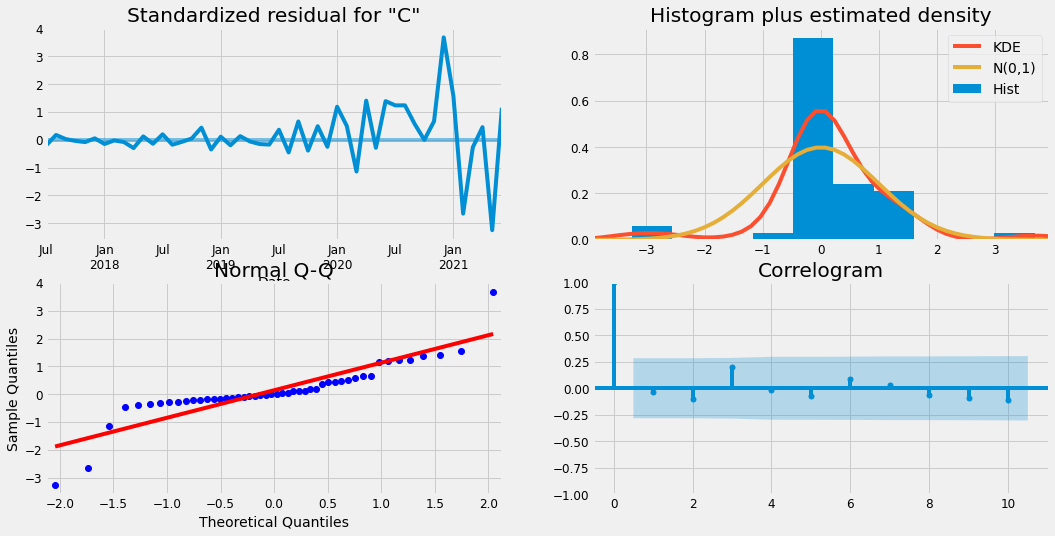

In [20]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

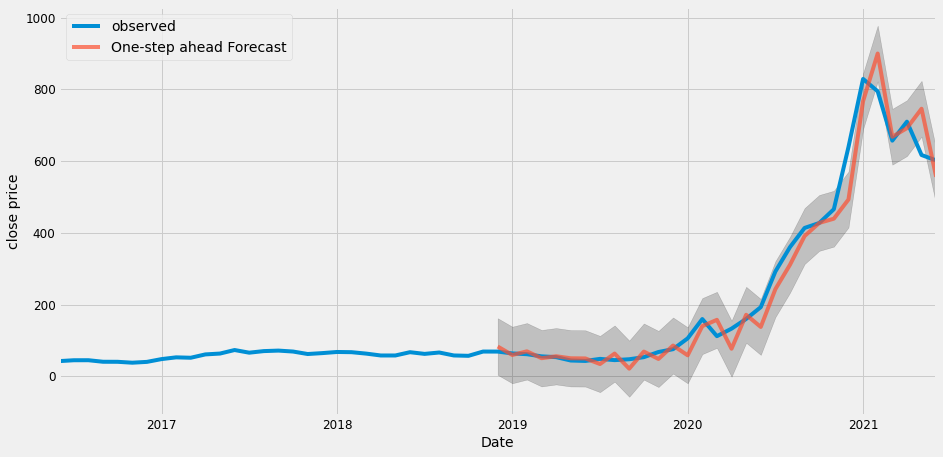

In [21]:
pred = results.get_prediction(start=pd.to_datetime('2018-12-31'), dynamic=False)
pred_ci = pred.conf_int()

ax = monthly_mean['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('close price')
plt.legend()

plt.show()

In [22]:
y_forecasted = pred.predicted_mean
y_truth = monthly_mean['2018-12-31':]

# Compute the mean square error
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 2414.5


In [23]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 49.14


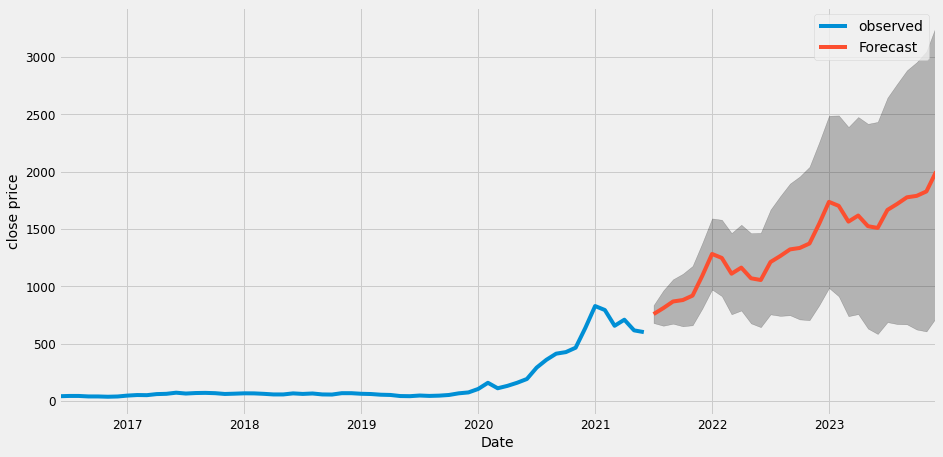

In [24]:
pred_uc = results.get_forecast(steps=30)
pred_ci = pred_uc.conf_int()

ax = monthly_mean.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('close price')

plt.legend()
plt.show()

# TEXTUAL ANALYSIS

In [25]:
# Import libraries
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from urllib.request import urlopen, Request
from nltk.sentiment.vader import SentimentIntensityAnalyzer



In [26]:
# Parameters 
n = 3 #the # of article headlines displayed per ticker
tickers = ['TSLA']

To get started, first import the following modules and set the parameters to your preference. 

In [27]:
# Get Data
finviz_url = 'https://finviz.com/quote.ashx?t='
news_tables = {}

for ticker in tickers:
    url = finviz_url + ticker
    req = Request(url=url,headers={'user-agent': 'my-app/0.0.1'}) 
    resp = urlopen(req)    
    html = BeautifulSoup(resp, features="lxml")
    news_table = html.find(id='news-table')
    news_tables[ticker] = news_table

try:
    for ticker in tickers:
        df = news_tables[ticker]
        df_tr = df.findAll('tr')
    
        print ('\n')
        print ('Recent News Headlines for {}: '.format(ticker))
        
        for i, table_row in enumerate(df_tr):
            a_text = table_row.a.text
            td_text = table_row.td.text
            td_text = td_text.strip()
            print(a_text,'(',td_text,')')
            if i == n-1:
                break
except KeyError:
    pass




Recent News Headlines for TSLA: 
How A 100 Year Old Science Experiment Helped Create The Fuel Of The Future ( Jun-08-21 07:00PM )
Mercedes-Benz USA CEO on strong 2021 sales and EV future ( 04:38PM )
Replay: EVgo and Climate Change Crisis Real Impact I Acquisition Corporation in Live Fireside Chat to Discuss Merger ( 04:20PM )


Next, we will get the news data from the FinViz website using the modules BeautifulSoup and requests. The code parses the URL for the HTML table of news and iterates through the list of tickers to gather the recent headlines for each ticker. For each inputted stock, an ‘n’ number of recent headlines is printed out so the data is easy to view.

In [28]:
# Iterate through the news
parsed_news = []
for file_name, news_table in news_tables.items():
    for x in news_table.findAll('tr'):
        text = x.a.get_text() 
        date_scrape = x.td.text.split()

        if len(date_scrape) == 1:
            time = date_scrape[0]
            
        else:
            date = date_scrape[0]
            time = date_scrape[1]

        ticker = file_name.split('_')[0]
        
        parsed_news.append([ticker, date, time, text])

In order to perform the sentiment analysis, the data must be in the proper format and so this piece of code iterates through the collected news and sorts it into a list of tickers, dates, times, and the actual headline.

In [29]:
# Sentiment Analysis
analyzer = SentimentIntensityAnalyzer()

columns = ['Ticker', 'Date', 'Time', 'Headline']
news = pd.DataFrame(parsed_news, columns=columns)
scores = news['Headline'].apply(analyzer.polarity_scores).tolist()

df_scores = pd.DataFrame(scores)
news = news.join(df_scores, rsuffix='_right')

Using the powerful nltk module, each headline is analyzed for its polarity score on a scale of -1 to 1, with -1 being highly negative and highly 1 being positive.


In [30]:
# View Data 
news['Date'] = pd.to_datetime(news.Date).dt.date

unique_ticker = news['Ticker'].unique().tolist()
news_dict = {name: news.loc[news['Ticker'] == name] for name in unique_ticker}

values = []
for ticker in tickers: 
    dataframe = news_dict[ticker]
    dataframe = dataframe.set_index('Ticker')
    dataframe = dataframe.drop(columns = ['Headline'])
    print ('\n')
    print (dataframe.head())
    
    mean = round(dataframe['compound'].mean(), 2)
    values.append(mean)
    
df = pd.DataFrame(list(zip(tickers, values)), columns =['Ticker', 'Mean Sentiment']) 
df = df.set_index('Ticker')
df = df.sort_values('Mean Sentiment', ascending=False)
print ('\n')
print (df)



              Date     Time    neg    neu    pos  compound
Ticker                                                    
TSLA    2021-06-08  07:00PM  0.000  0.851  0.149    0.2732
TSLA    2021-06-08  04:38PM  0.000  0.732  0.268    0.5106
TSLA    2021-06-08  04:20PM  0.204  0.796  0.000   -0.6249
TSLA    2021-06-08  04:06PM  0.000  1.000  0.000    0.0000
TSLA    2021-06-08  04:02PM  0.000  1.000  0.000    0.0000


        Mean Sentiment
Ticker                
TSLA              0.05


Finally, the data is ready to be manipulated and viewed in an appealing manner. For each ticker in the inputted list, a new DataFrame will be created that includes its headlines and their respective scores. Lastly, a final DataFrame will be created that includes each ticker’s mean sentiment value over all the recent news parsed.

**So we conclude that TESLA MOTORS is going to be moving upside in upcoming years to come**